# MERA

## Overview

In this tutorial, we'll show you how to implement MERA (multi-scale entangled renormalization ansatz) with TensorCircuit, but not in physics perspective.

## Background

MERA is a kind of VQE starts from only one qubit in the $\ket{0}$ state, and progressively enlarges the Hilbert space by tensoring on new qubits.
In the MERA we are going to train (denoted by $U(\theta)$), we use parameterized quantum gates $e^{i\theta XX}$, $e^{i\theta ZZ}$ as two-qubit gates and $e^{i\theta X}$, $e^{i\theta Z}$ as single-qubit gates.
The Hamiltonian we choose as the example is from TFIM as $\hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}}$. 
And the loss function to be minimized in this task is $\mathcal{L}_{MERA}(\rm{\theta})=\langle 0^n\vert U(\theta)^\dagger \hat{H} U(\theta)\vert 0^n\rangle$. 

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## Energy
We first design the Hamiltonian energy expectation function as loss.
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [2]:
def energy(c: tc.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    # <Z_i Z_{i+1}>
    for i in range(n - 1):
        e += j * c.expectation((tc.gates.z(), [i]), (tc.gates.z(), [i + 1]))
    # <X_i>
    for i in range(n):
        e -= hx * c.expectation((tc.gates.x(), [i]))
    return tc.backend.real(e)

## MERA circuit

Now we design the circuit. We use $\theta$ as input.

In [5]:
def MERA(params, n):
    params = tc.backend.cast(params, "complex128")
    c = tc.Circuit(n)

    idx = 0  # index of params

    for i in range(n):
        c.rx(i, theta=params[2 * i])
        c.rz(i, theta=params[2 * i + 1])
    idx += 2 * n

    for n_layer in range(1, int(np.log2(n)) + 1):
        n_qubit = 2**n_layer  # number of qubits involving
        step = int(n / n_qubit)

        # even
        for i in range(step, n - step, 2 * step):
            c.exp1(i, i + step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i + step, theta=params[idx + 1], unitary=tc.gates._zz_matrix)
            idx += 2

        # odd
        for i in range(0, n, 2 * step):
            c.exp1(i, i + step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i + step, theta=params[idx + 1], unitary=tc.gates._zz_matrix)
            idx += 2

        # single qubit
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx + 1])
            idx += 2

    # measure
    e = energy(c)
    return e
    # return c, idx

We can visualize the MERA circuit. 

Hint: Please change return to `return c, idx`, which will only be used here. After visulization, don't forget to restore the return and run the code block above again.

The number of parameters is 66


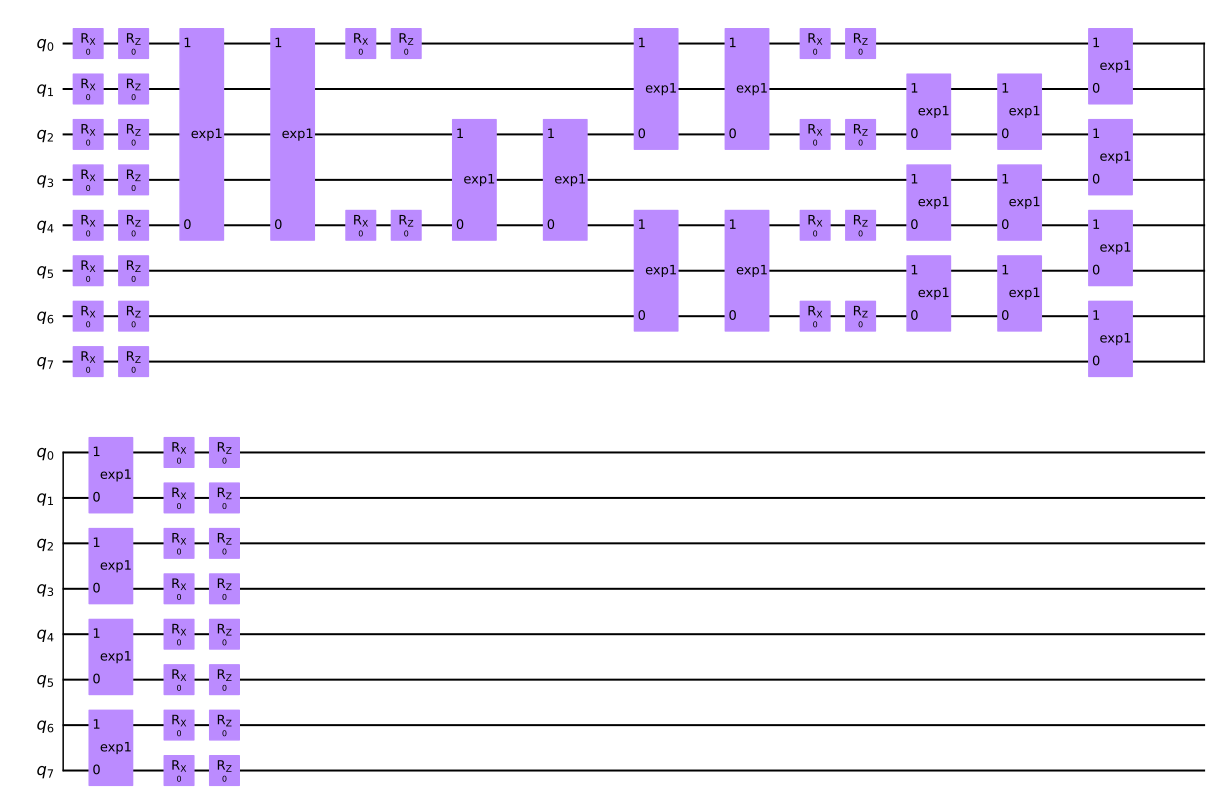

In [4]:
n = 8
cirq, idx = MERA(np.zeros(1000), n)
print("The number of parameters is", idx)
cirq.draw()

## Train

Now we can train the MERA circuit with tensorflow.

In [6]:
MERA_tfim_vvag = tc.backend.jit(tc.backend.vectorized_value_and_grad(MERA))


def batched_train(n, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    for i in range(maxiter):
        e, grad = MERA_tfim_vvag(params, n)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e) < lowest_energy:
            lowest_energy = tf.reduce_min(e)
        if i % 200 == 0:
            print(e)
    return lowest_energy


n = 8
lowest_energy = batched_train(n, batch=5, maxiter=2000, lr=0.007)

tf.Tensor([-0.6449017   0.14083987  0.17227418  1.42731099  0.93767164], shape=(5,), dtype=float64)
tf.Tensor([-9.57952648 -9.15354269 -9.53415983 -9.55291257 -9.46880555], shape=(5,), dtype=float64)
tf.Tensor([-9.63166728 -9.60922826 -9.59883555 -9.66639936 -9.60174669], shape=(5,), dtype=float64)
tf.Tensor([-9.65441326 -9.61830383 -9.6219077  -9.68289435 -9.61427165], shape=(5,), dtype=float64)
tf.Tensor([-9.66991104 -9.6307931  -9.64993901 -9.71396225 -9.63848947], shape=(5,), dtype=float64)
tf.Tensor([-9.67960751 -9.64303661 -9.67696885 -9.76317346 -9.6507455 ], shape=(5,), dtype=float64)
tf.Tensor([-9.68303361 -9.6575349  -9.70118521 -9.7740601  -9.65751254], shape=(5,), dtype=float64)
tf.Tensor([-9.68481667 -9.67473162 -9.71392119 -9.78200161 -9.66880068], shape=(5,), dtype=float64)
tf.Tensor([-9.6864865  -9.67835678 -9.73033137 -9.79128949 -9.68317883], shape=(5,), dtype=float64)
tf.Tensor([-9.68762425 -9.67928153 -9.77502182 -9.79465957 -9.69252806], shape=(5,), dtype=float64)


## Compare

We can compare the ground energy we get by MERA with DMRG.

In [7]:
# DMRG
import quimb

h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4.0, bx=2.0, S=0.5, cyclic=False)
dmrg = quimb.tensor.tensor_dmrg.DMRG(
    h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13
)
dmrg.solve(tol=1e-9, verbosity=0)
energy_DMRG = dmrg.energy

# Compare
print("DMRG solution: ", energy_DMRG)
print("MERA solution: ", lowest_energy.numpy())

DMRG solution:  -9.837951447459426
MERA solution:  -9.795198473308487
